In [ ]:
Apip install tensorflow numpy matplotlib seaborn scikit-learn adversarial-robustness-toolbox pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# -----------------------------#
#         ResNet32 Class        #
# -----------------------------#

class ResNet32:
    def __init__(self, input_shape, num_classes, num_blocks=3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_blocks = num_blocks  # Number of residual blocks per stage
        self.model = self.build_model()

    def resnet_block(self, x, filters, kernel_size=3, stride=1):
        shortcut = x
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([shortcut, x])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def build_model(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        x = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 16)
        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 32, stride=2)
        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 64, stride=2)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)

        model = tf.keras.Model(inputs, outputs)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
# -----------------------------#
#      Defended ResNet32 Class  #
# -----------------------------#

class DefendedResNet32(tf.keras.Model):
    def __init__(self, input_shape, num_classes, num_blocks=3, noise_std=0.1):
        super(DefendedResNet32, self).__init__()
        self.num_blocks = num_blocks
        self.noise_std = noise_std
        self.build_architecture(input_shape, num_classes)
        self.compile_model()

    def build_architecture(self, input_shape, num_classes):
        inputs = tf.keras.Input(shape=input_shape)
        x = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 16)
        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 32, stride=2)
        for _ in range(self.num_blocks):
            x = self.resnet_block(x, 64, stride=2)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

        self.model_architecture = tf.keras.Model(inputs, outputs)

    def resnet_block(self, x, filters, kernel_size=3, stride=1):
        shortcut = x
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([shortcut, x])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def compile_model(self):
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.metrics_list = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
        self.compile(optimizer=self.optimizer, loss=self.loss_fn, metrics=self.metrics_list)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.model_architecture(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.model_architecture.trainable_variables)
        # Gradient Masking: thêm nhiễu Gaussian vào gradients
        noise = [tf.random.normal(shape=tf.shape(g), mean=0.0, stddev=self.noise_std) for g in gradients]
        gradients_noisy = [g + n for g, n in zip(gradients, noise)]
        # Áp dụng gradients đã bị nhiễu
        self.optimizer.apply_gradients(zip(gradients_noisy, self.model_architecture.trainable_variables))
        # Cập nhật metrics
        self.compiled_metrics.update_state(y, y_pred)
        # Trả về dictionary các metrics
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs):
        return self.model_architecture(inputs)


In [ ]:
# -----------------------------#
#      Data Loading and Preprocessing      #
# -----------------------------#

# Load CIFAR-10 dataset from Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten labels from 2D to 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# Convert labels to one-hot encoding
num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Split data into training and validation sets
x_train, x_val, y_train_cat, y_val_cat, y_train_int, y_val_int = train_test_split(
    x_train, y_train_cat, y_train, test_size=0.15, random_state=42
)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (42500, 32, 32, 3)
Validation data shape: (7500, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [ ]:
# -----------------------------#
#      Label Flipping Attack    #
# -----------------------------#

def flip_labels(y, flip_rate=0.1, num_classes=10, random_state=42):
    """
    Flip a percentage of labels to a different class.

    :param y: Original labels (one-hot encoded)
    :param flip_rate: Fraction of labels to flip
    :param num_classes: Total number of classes
    :param random_state: Seed for reproducibility
    :return: Flipped labels, indices of flipped labels
    """
    np.random.seed(random_state)
    y_flipped = np.copy(y)
    n_flip = int(len(y) * flip_rate)
    flip_indices = np.random.choice(len(y), n_flip, replace=False)
    for idx in flip_indices:
        original_label = np.argmax(y_flipped[idx])
        new_label = np.random.choice([i for i in range(num_classes) if i != original_label])
        y_flipped[idx] = 0
        y_flipped[idx][new_label] = 1
    return y_flipped, flip_indices

In [ ]:
# -----------------------------#
#          Training             #
# -----------------------------#

# Create the original ResNet32 model
input_shape = x_train.shape[1:]
model_original = ResNet32(input_shape=input_shape, num_classes=num_classes).model

# Train the original model
print("\nTraining Original ResNet32 Model...")
history_original = model_original.fit(
    x_train, y_train_cat,
    epochs=10,  # Adjust epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(x_val, y_val_cat),
    verbose=2
)

# Evaluate the original model on clean test data
test_loss, test_acc = model_original.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy before attack: {test_acc:.4f}")



Training Original ResNet32 Model...
Epoch 1/10
665/665 - 435s - 654ms/step - accuracy: 0.2962 - loss: 1.9352 - val_accuracy: 0.3948 - val_loss: 1.6601
Epoch 2/10
665/665 - 431s - 649ms/step - accuracy: 0.4612 - loss: 1.4936 - val_accuracy: 0.4536 - val_loss: 1.5220
Epoch 3/10
665/665 - 432s - 650ms/step - accuracy: 0.5404 - loss: 1.3044 - val_accuracy: 0.5340 - val_loss: 1.3139
Epoch 4/10
665/665 - 500s - 752ms/step - accuracy: 0.5922 - loss: 1.1726 - val_accuracy: 0.5568 - val_loss: 1.2943
Epoch 5/10
665/665 - 451s - 678ms/step - accuracy: 0.6341 - loss: 1.0568 - val_accuracy: 0.5801 - val_loss: 1.2068
Epoch 6/10
665/665 - 452s - 680ms/step - accuracy: 0.6697 - loss: 0.9649 - val_accuracy: 0.5707 - val_loss: 1.2495
Epoch 7/10
665/665 - 419s - 630ms/step - accuracy: 0.7018 - loss: 0.8730 - val_accuracy: 0.6128 - val_loss: 1.1568
Epoch 8/10
665/665 - 408s - 614ms/step - accuracy: 0.7293 - loss: 0.7947 - val_accuracy: 0.6165 - val_loss: 1.2061
Epoch 9/10
665/665 - 441s - 663ms/step - ac

In [ ]:
# -----------------------------#
#       Perform Label Flipping Attack    #
# -----------------------------#

# Define flip rate (e.g., 20% of the training data)
flip_rate = 0.2  # 20%

# Apply label flipping attack
y_train_poisoned_cat, flipped_indices = flip_labels(y_train_cat, flip_rate=flip_rate, num_classes=num_classes)
print(f"Số lượng mẫu bị nhiễu (Label Flipping): {len(flipped_indices)}")

Số lượng mẫu bị nhiễu (Label Flipping): 8500


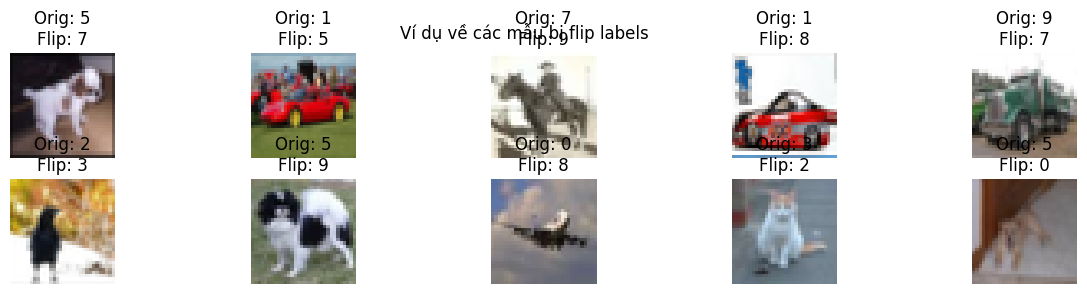

In [ ]:
# Visualize some flipped labels
plt.figure(figsize=(15,3))
for i, idx in enumerate(flipped_indices[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[idx])
    original_label = y_train_int[idx]
    flipped_label = np.argmax(y_train_poisoned_cat[idx])
    plt.title(f"Orig: {original_label}\nFlip: {flipped_label}")
    plt.axis('off')
plt.suptitle("Ví dụ về các mẫu bị flip labels")
plt.show()

In [ ]:
# Create a new ResNet32 model for poisoned data
model_poisoned = ResNet32(input_shape=input_shape, num_classes=num_classes).model

# Train the poisoned model
print("\nTraining Poisoned ResNet32 Model with Label Flipping...")
history_poisoned = model_poisoned.fit(
    x_train, y_train_poisoned_cat,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    verbose=2
)

# Evaluate the poisoned model on clean test data
test_loss_poisoned, test_acc_poisoned = model_poisoned.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy after attack on clean data: {test_acc_poisoned:.4f}")


Training Poisoned ResNet32 Model with Label Flipping...
Epoch 1/10
665/665 - 487s - 732ms/step - accuracy: 0.2209 - loss: 2.1940 - val_accuracy: 0.3799 - val_loss: 1.7493
Epoch 2/10
665/665 - 446s - 671ms/step - accuracy: 0.3373 - loss: 1.9396 - val_accuracy: 0.4391 - val_loss: 1.5805
Epoch 3/10
665/665 - 415s - 624ms/step - accuracy: 0.3856 - loss: 1.8447 - val_accuracy: 0.4605 - val_loss: 1.5536
Epoch 4/10
665/665 - 443s - 666ms/step - accuracy: 0.4212 - loss: 1.7837 - val_accuracy: 0.4244 - val_loss: 1.6641
Epoch 5/10
665/665 - 440s - 662ms/step - accuracy: 0.4611 - loss: 1.7104 - val_accuracy: 0.4803 - val_loss: 1.5167
Epoch 6/10
665/665 - 405s - 608ms/step - accuracy: 0.4943 - loss: 1.6461 - val_accuracy: 0.5296 - val_loss: 1.3870
Epoch 7/10
665/665 - 435s - 654ms/step - accuracy: 0.5204 - loss: 1.5903 - val_accuracy: 0.4985 - val_loss: 1.4716
Epoch 8/10
665/665 - 410s - 617ms/step - accuracy: 0.5460 - loss: 1.5337 - val_accuracy: 0.5665 - val_loss: 1.3045
Epoch 9/10
665/665 - 45

In [ ]:
# -----------------------------#
#          Defended Model       #
# -----------------------------#
# Create the defended ResNet32 model
model_defended = DefendedResNet32(input_shape=input_shape, num_classes=num_classes).model

# Train the defended model on poisoned data
print("\nTraining Defended ResNet32 Model with Label Flipping...")
history_defended = model_defended.fit(
    x_train, y_train_poisoned_cat,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    verbose=2
)

# Evaluate the defended model on clean test data
test_loss_defended, test_acc_defended = model_defended.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy of defended model on clean data: {test_acc_defended:.4f}")


Training Defended ResNet32 Model with Label Flipping...
Epoch 1/10
665/665 - 440s - 661ms/step - accuracy: 0.2230 - loss: 2.1971 - val_accuracy: 0.3520 - val_loss: 1.7944
Epoch 2/10
665/665 - 430s - 647ms/step - accuracy: 0.3385 - loss: 1.9334 - val_accuracy: 0.4197 - val_loss: 1.6479
Epoch 3/10
665/665 - 410s - 617ms/step - accuracy: 0.3926 - loss: 1.8366 - val_accuracy: 0.4300 - val_loss: 1.6453
Epoch 4/10
665/665 - 408s - 613ms/step - accuracy: 0.4336 - loss: 1.7586 - val_accuracy: 0.3868 - val_loss: 1.7415
Epoch 5/10
665/665 - 439s - 660ms/step - accuracy: 0.4722 - loss: 1.6900 - val_accuracy: 0.5279 - val_loss: 1.3920
Epoch 6/10
665/665 - 468s - 704ms/step - accuracy: 0.5007 - loss: 1.6243 - val_accuracy: 0.4876 - val_loss: 1.5074
Epoch 7/10
665/665 - 420s - 631ms/step - accuracy: 0.5307 - loss: 1.5623 - val_accuracy: 0.5467 - val_loss: 1.3569
Epoch 8/10
665/665 - 411s - 619ms/step - accuracy: 0.5528 - loss: 1.5044 - val_accuracy: 0.5495 - val_loss: 1.3546
Epoch 9/10
665/665 - 43

In [ ]:
# -----------------------------#
#           Metrics             #
# -----------------------------#

def get_metrics(model, x, y_true):
    """
    Compute accuracy, precision, recall, and F1-score.

    :param model: Trained Keras model
    :param x: Input data
    :param y_true: True labels (one-hot encoded)
    :return: Tuple of (accuracy, precision, recall, f1_score)
    """
    y_pred_probs = model.predict(x, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_int = np.argmax(y_true, axis=1)
    accuracy = accuracy_score(y_true_int, y_pred)
    precision = precision_score(y_true_int, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true_int, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true_int, y_pred, average='macro', zero_division=0)
    return accuracy, precision, recall, f1

In [ ]:
# Compute metrics for clean test data
acc_clean_original, prec_clean_original, rec_clean_original, f1_clean_original = get_metrics(model_original, x_test, y_test_cat)
acc_clean_poisoned, prec_clean_poisoned, rec_clean_poisoned, f1_clean_poisoned = get_metrics(model_poisoned, x_test, y_test_cat)
acc_clean_defended, prec_clean_defended, rec_clean_defended, f1_clean_defended = get_metrics(model_defended, x_test, y_test_cat)

# Since label flipping doesn't involve triggers, we'll skip triggered data evaluation
# Create results dataframe
df_results = pd.DataFrame({
    'Model': ['Original', 'Poisoned', 'Defended'],
    'Accuracy (Clean)': [acc_clean_original, acc_clean_poisoned, acc_clean_defended],
    'Precision (Clean)': [prec_clean_original, prec_clean_poisoned, prec_clean_defended],
    'Recall (Clean)': [rec_clean_original, rec_clean_poisoned, rec_clean_defended],
    'F1-Score (Clean)': [f1_clean_original, f1_clean_poisoned, f1_clean_defended],
})

print("\nMetrics Comparison:")
print(df_results)


Metrics Comparison:
      Model  Accuracy (Clean)  Precision (Clean)  Recall (Clean)  \
0  Original            0.6531           0.660563          0.6531   
1  Poisoned            0.5059           0.538723          0.5059   
2  Defended            0.5715           0.581554          0.5715   

   F1-Score (Clean)  
0          0.653159  
1          0.508614  
2          0.571553  


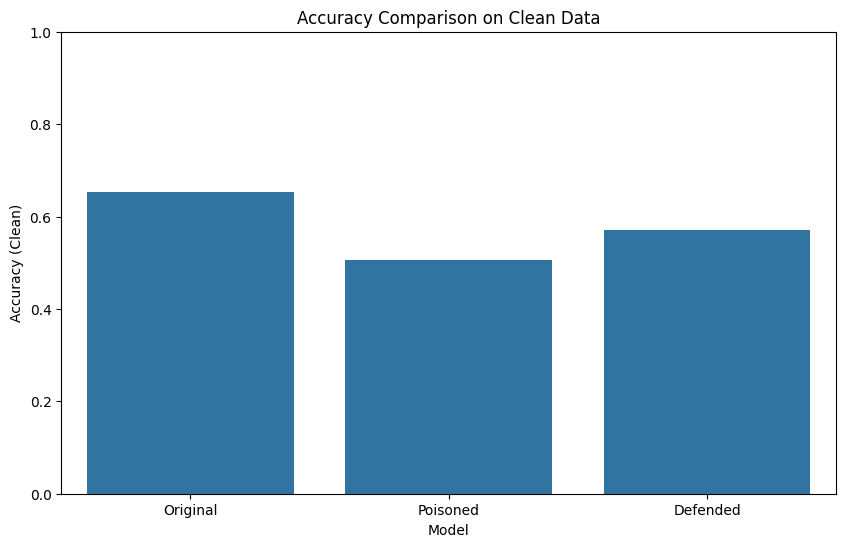

In [ ]:
# Bar Plot: Accuracy Comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy (Clean)', data=df_results)
plt.title("Accuracy Comparison on Clean Data")
plt.ylim(0,1)
plt.show()

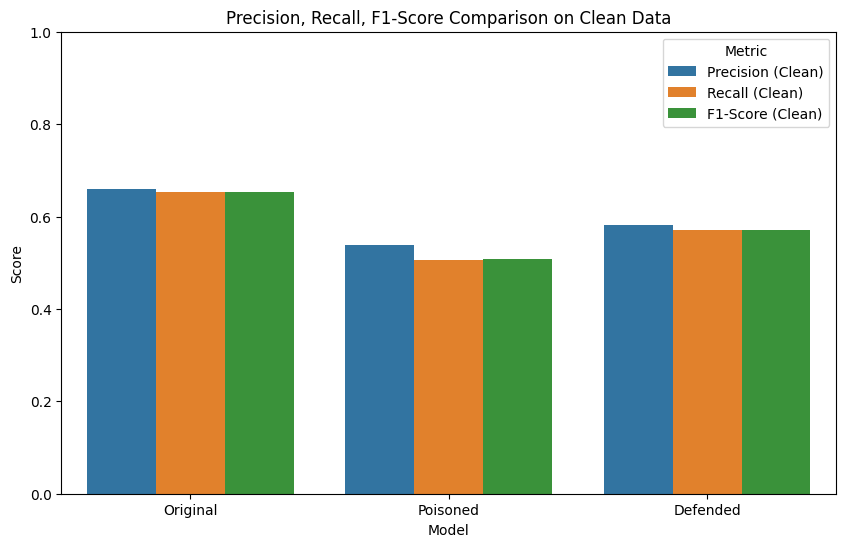

In [ ]:
# Bar Plot: Precision, Recall, F1-Score Comparison
df_metrics = df_results.melt(id_vars='Model', value_vars=['Precision (Clean)', 'Recall (Clean)', 'F1-Score (Clean)'],
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_metrics)
plt.title("Precision, Recall, F1-Score Comparison on Clean Data")
plt.ylim(0,1)
plt.show()

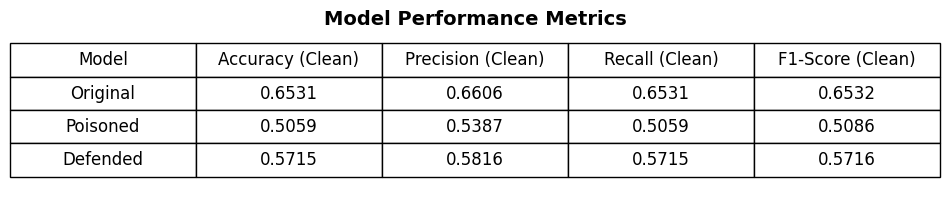

In [ ]:
# Function to display DataFrame as a table
def plot_table(df, title="Model Performance Metrics"):
    fig, ax = plt.subplots(figsize=(12, 2))  # Adjust size as needed
    ax.axis('off')
    # Separate numeric and non-numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_display = df.copy()
    df_display[numeric_cols] = np.round(df_display[numeric_cols], 4)
    table = ax.table(cellText=df_display.values,
                     colLabels=df_display.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Plot the metrics table
plot_table(df_results, title="Model Performance Metrics")

In [ ]:
# -----------------------------#
#          Metrics Plots        #
# -----------------------------#

# Function to plot bar charts for different metrics
def plot_metrics(df, metric, title):
    plt.figure(figsize=(8,6))
    sns.barplot(x='Model', y=metric, data=df)
    plt.title(title)
    plt.ylim(0,1)
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.show()

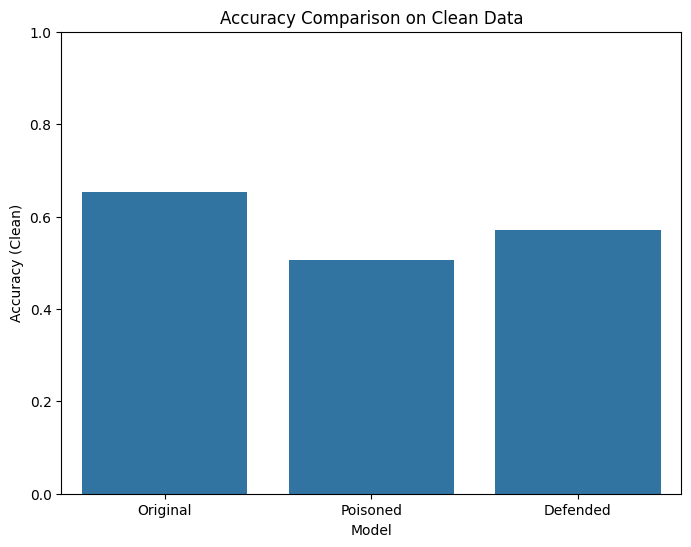

In [ ]:
# Plot Accuracy
plot_metrics(df_results, 'Accuracy (Clean)', 'Accuracy Comparison on Clean Data')

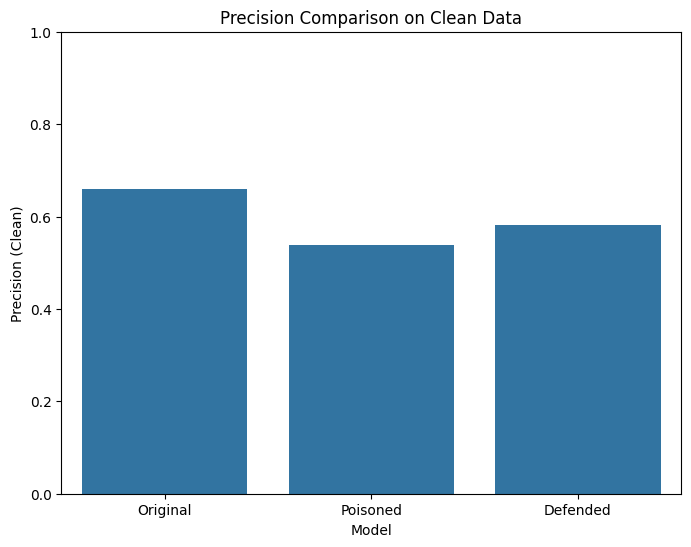

In [ ]:
# Plot Precision
plot_metrics(df_results, 'Precision (Clean)', 'Precision Comparison on Clean Data')

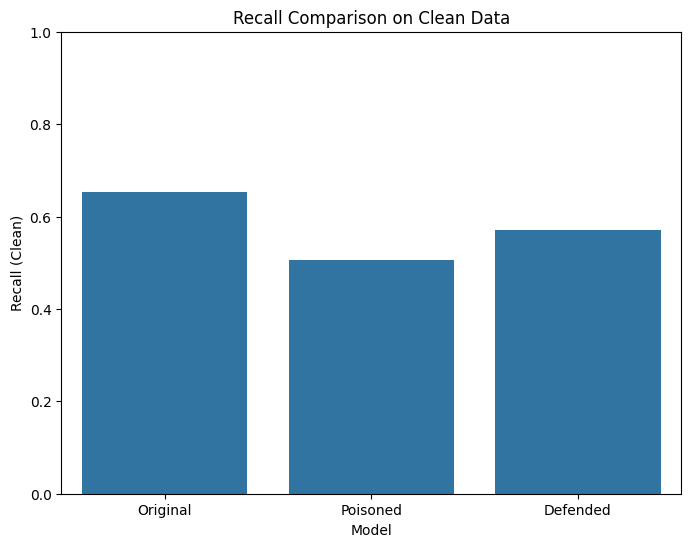

In [ ]:
# Plot Recall
plot_metrics(df_results, 'Recall (Clean)', 'Recall Comparison on Clean Data')

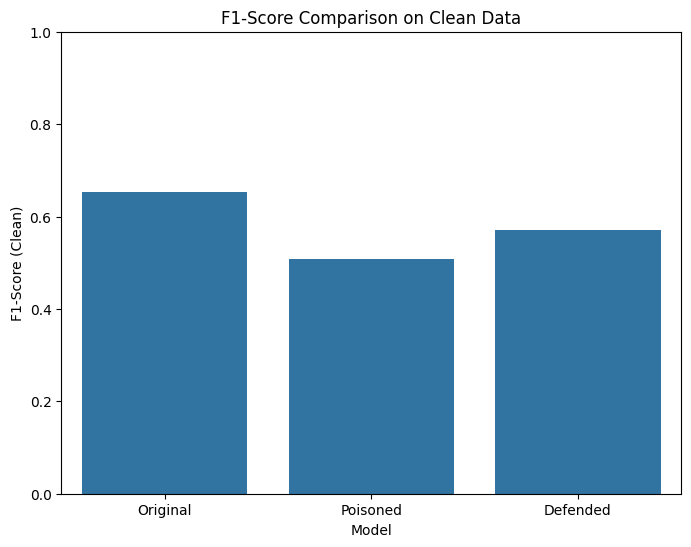

In [ ]:
# Plot F1-Score
plot_metrics(df_results, 'F1-Score (Clean)', 'F1-Score Comparison on Clean Data')